In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import re
import random
import operator
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from func import *

# inline plot
%matplotlib inline

In [2]:
#%load 'data/raw-twt2016-01-26-14/21/09.csv'
df = pd.read_csv("data/raw-twt2016-01-26-14-21-09.csv",sep='\t',error_bad_lines=False)
df.head(5)

,Unnamed: 0,created_at,favorite_count,favorited,hashtags,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,...,place,retweet_count,retweeted,retweeted_status,source,text,truncated,urls,user,user_mentions
0,0,Tue Jan 26 20:32:15 +0000 2016,6,False,[SanFrancisco],692082643022680064,NaN,NaN,NaN,en,...,NaN,7,False,NaN,"<a href=""https://about.twitter.com/products/tw...",NOTICE: Ped &amp; Bike detours in place for Ma...,False,{u'https://t.co/hcYGYF5L5S': u'https://www.sfm...,"{u'id': 456808166, u'verified': True, u'profil...",NaN
1,1,Tue Jan 26 19:41:32 +0000 2016,NaN,False,NaN,692069881559134208,therealwall,6.920673e+17,46136761,en,...,NaN,NaN,False,NaN,"<a href=""https://about.twitter.com/products/tw...",@therealwall After the end of the concert we w...,False,{u'https://t.co/3f9VEAaGTY': u'http://www.calt...,"{u'id': 456808166, u'verified': True, u'profil...","[{u'screen_name': u'therealwall', u'id': 46136..."
2,2,Tue Jan 26 19:28:52 +0000 2016,NaN,False,[SB50],692066695838498816,AemalTheAFGHAN,6.920578e+17,291505788,en,...,NaN,NaN,False,NaN,"<a href=""https://about.twitter.com/products/tw...",@AemalTheAFGHAN @BKDenverSports We're glad to ...,False,{u'https://t.co/fgMOSXplzZ': u'http://www.calt...,"{u'id': 456808166, u'verified': True, u'profil...","[{u'screen_name': u'AemalTheAFGHAN', u'id': 29..."
3,3,Tue Jan 26 18:12:35 +0000 2016,1,False,"[Sorry, Headphones]",692047497238175744,4c4d,6.920436e+17,256648931,en,...,NaN,NaN,False,NaN,"<a href=""https://about.twitter.com/products/tw...","@4c4d Oh man. We love that, too. Our favorite ...",False,NaN,"{u'id': 456808166, u'verified': True, u'profil...","[{u'screen_name': u'4c4d', u'id': 256648931, u..."
4,4,Tue Jan 26 17:53:20 +0000 2016,7,False,NaN,692042650933862401,NaN,NaN,NaN,en,...,NaN,18,False,NaN,"<a href=""https://about.twitter.com/products/tw...","Pssst, hey, regular Caltrain riders: expect a ...",False,NaN,"{u'id': 456808166, u'verified': True, u'profil...",NaN


Cleanin' the data

In [3]:
# Fill in blank hashtags
df["hashtags"].fillna('')

# Add some date/time things
df["created_at"] = pd.to_datetime(df["created_at"], coerce=True)
df["day_of_week"] = df["created_at"].apply(lambda x: x.weekday())
df["day_of_month"] = df["created_at"].apply(lambda x: x.day)
df["month"] = df["created_at"].apply(lambda x: x.month)
df["time_of_day"] = df["created_at"].apply(lambda x: get_time_of_day(x))


df["hashtags"].fillna('')
df["hashtags"] = df["hashtags"].apply(lambda x: str(x)[1:-1])

/Users/albarron/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead


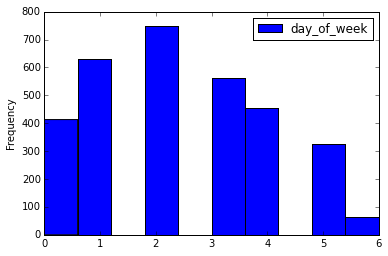

In [4]:
df.plot(x='created_at', y='day_of_week', kind='hist')
# fdf = df[["created_at","id","text","hashtags"]]
# str(fdf

In [5]:
df.head(5)

,Unnamed: 0,created_at,favorite_count,favorited,hashtags,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,...,source,text,truncated,urls,user,user_mentions,day_of_week,day_of_month,month,time_of_day
0,0,2016-01-26 20:32:15,6,False,SanFrancisco,692082643022680064,NaN,NaN,NaN,en,...,"<a href=""https://about.twitter.com/products/tw...",NOTICE: Ped &amp; Bike detours in place for Ma...,False,{u'https://t.co/hcYGYF5L5S': u'https://www.sfm...,"{u'id': 456808166, u'verified': True, u'profil...",NaN,1,26,1,0
1,1,2016-01-26 19:41:32,NaN,False,a,692069881559134208,therealwall,6.920673e+17,46136761,en,...,"<a href=""https://about.twitter.com/products/tw...",@therealwall After the end of the concert we w...,False,{u'https://t.co/3f9VEAaGTY': u'http://www.calt...,"{u'id': 456808166, u'verified': True, u'profil...","[{u'screen_name': u'therealwall', u'id': 46136...",1,26,1,3
2,2,2016-01-26 19:28:52,NaN,False,SB50,692066695838498816,AemalTheAFGHAN,6.920578e+17,291505788,en,...,"<a href=""https://about.twitter.com/products/tw...",@AemalTheAFGHAN @BKDenverSports We're glad to ...,False,{u'https://t.co/fgMOSXplzZ': u'http://www.calt...,"{u'id': 456808166, u'verified': True, u'profil...","[{u'screen_name': u'AemalTheAFGHAN', u'id': 29...",1,26,1,3
3,3,2016-01-26 18:12:35,1,False,"Sorry, Headphones",692047497238175744,4c4d,6.920436e+17,256648931,en,...,"<a href=""https://about.twitter.com/products/tw...","@4c4d Oh man. We love that, too. Our favorite ...",False,NaN,"{u'id': 456808166, u'verified': True, u'profil...","[{u'screen_name': u'4c4d', u'id': 256648931, u...",1,26,1,3
4,4,2016-01-26 17:53:20,7,False,a,692042650933862401,NaN,NaN,NaN,en,...,"<a href=""https://about.twitter.com/products/tw...","Pssst, hey, regular Caltrain riders: expect a ...",False,NaN,"{u'id': 456808166, u'verified': True, u'profil...",NaN,1,26,1,3


In [24]:
t = re.search('[N,S]B[0-9]{0,3}',df["hashtags"][16])
t.group()

'NB155'

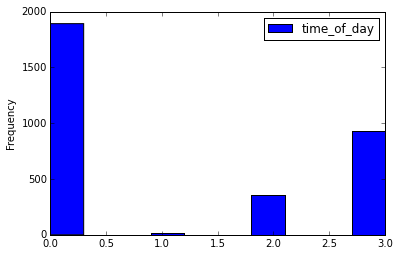

In [18]:
df.plot(x='day_of_week', y='time_of_day', kind='hist')